In [261]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
import tqdm
from tqdm import tqdm
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
import json
from sklearn.model_selection import KFold

# Создадим модель, которая предсказывает цену дома по его характеристискам

In [221]:
HouseDF = pd.read_csv("train.csv")

## 1. Посмотрим на данные

In [222]:
HouseDF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [223]:
HouseDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Построим матрицу корреляций

In [224]:
HouseDF_numeric = HouseDF.copy()
for column in HouseDF.columns:
    if HouseDF[column].dtype == 'object':
        HouseDF_numeric.drop(column, axis = 1, inplace = True)
correlation_matrix = HouseDF_numeric.corr()

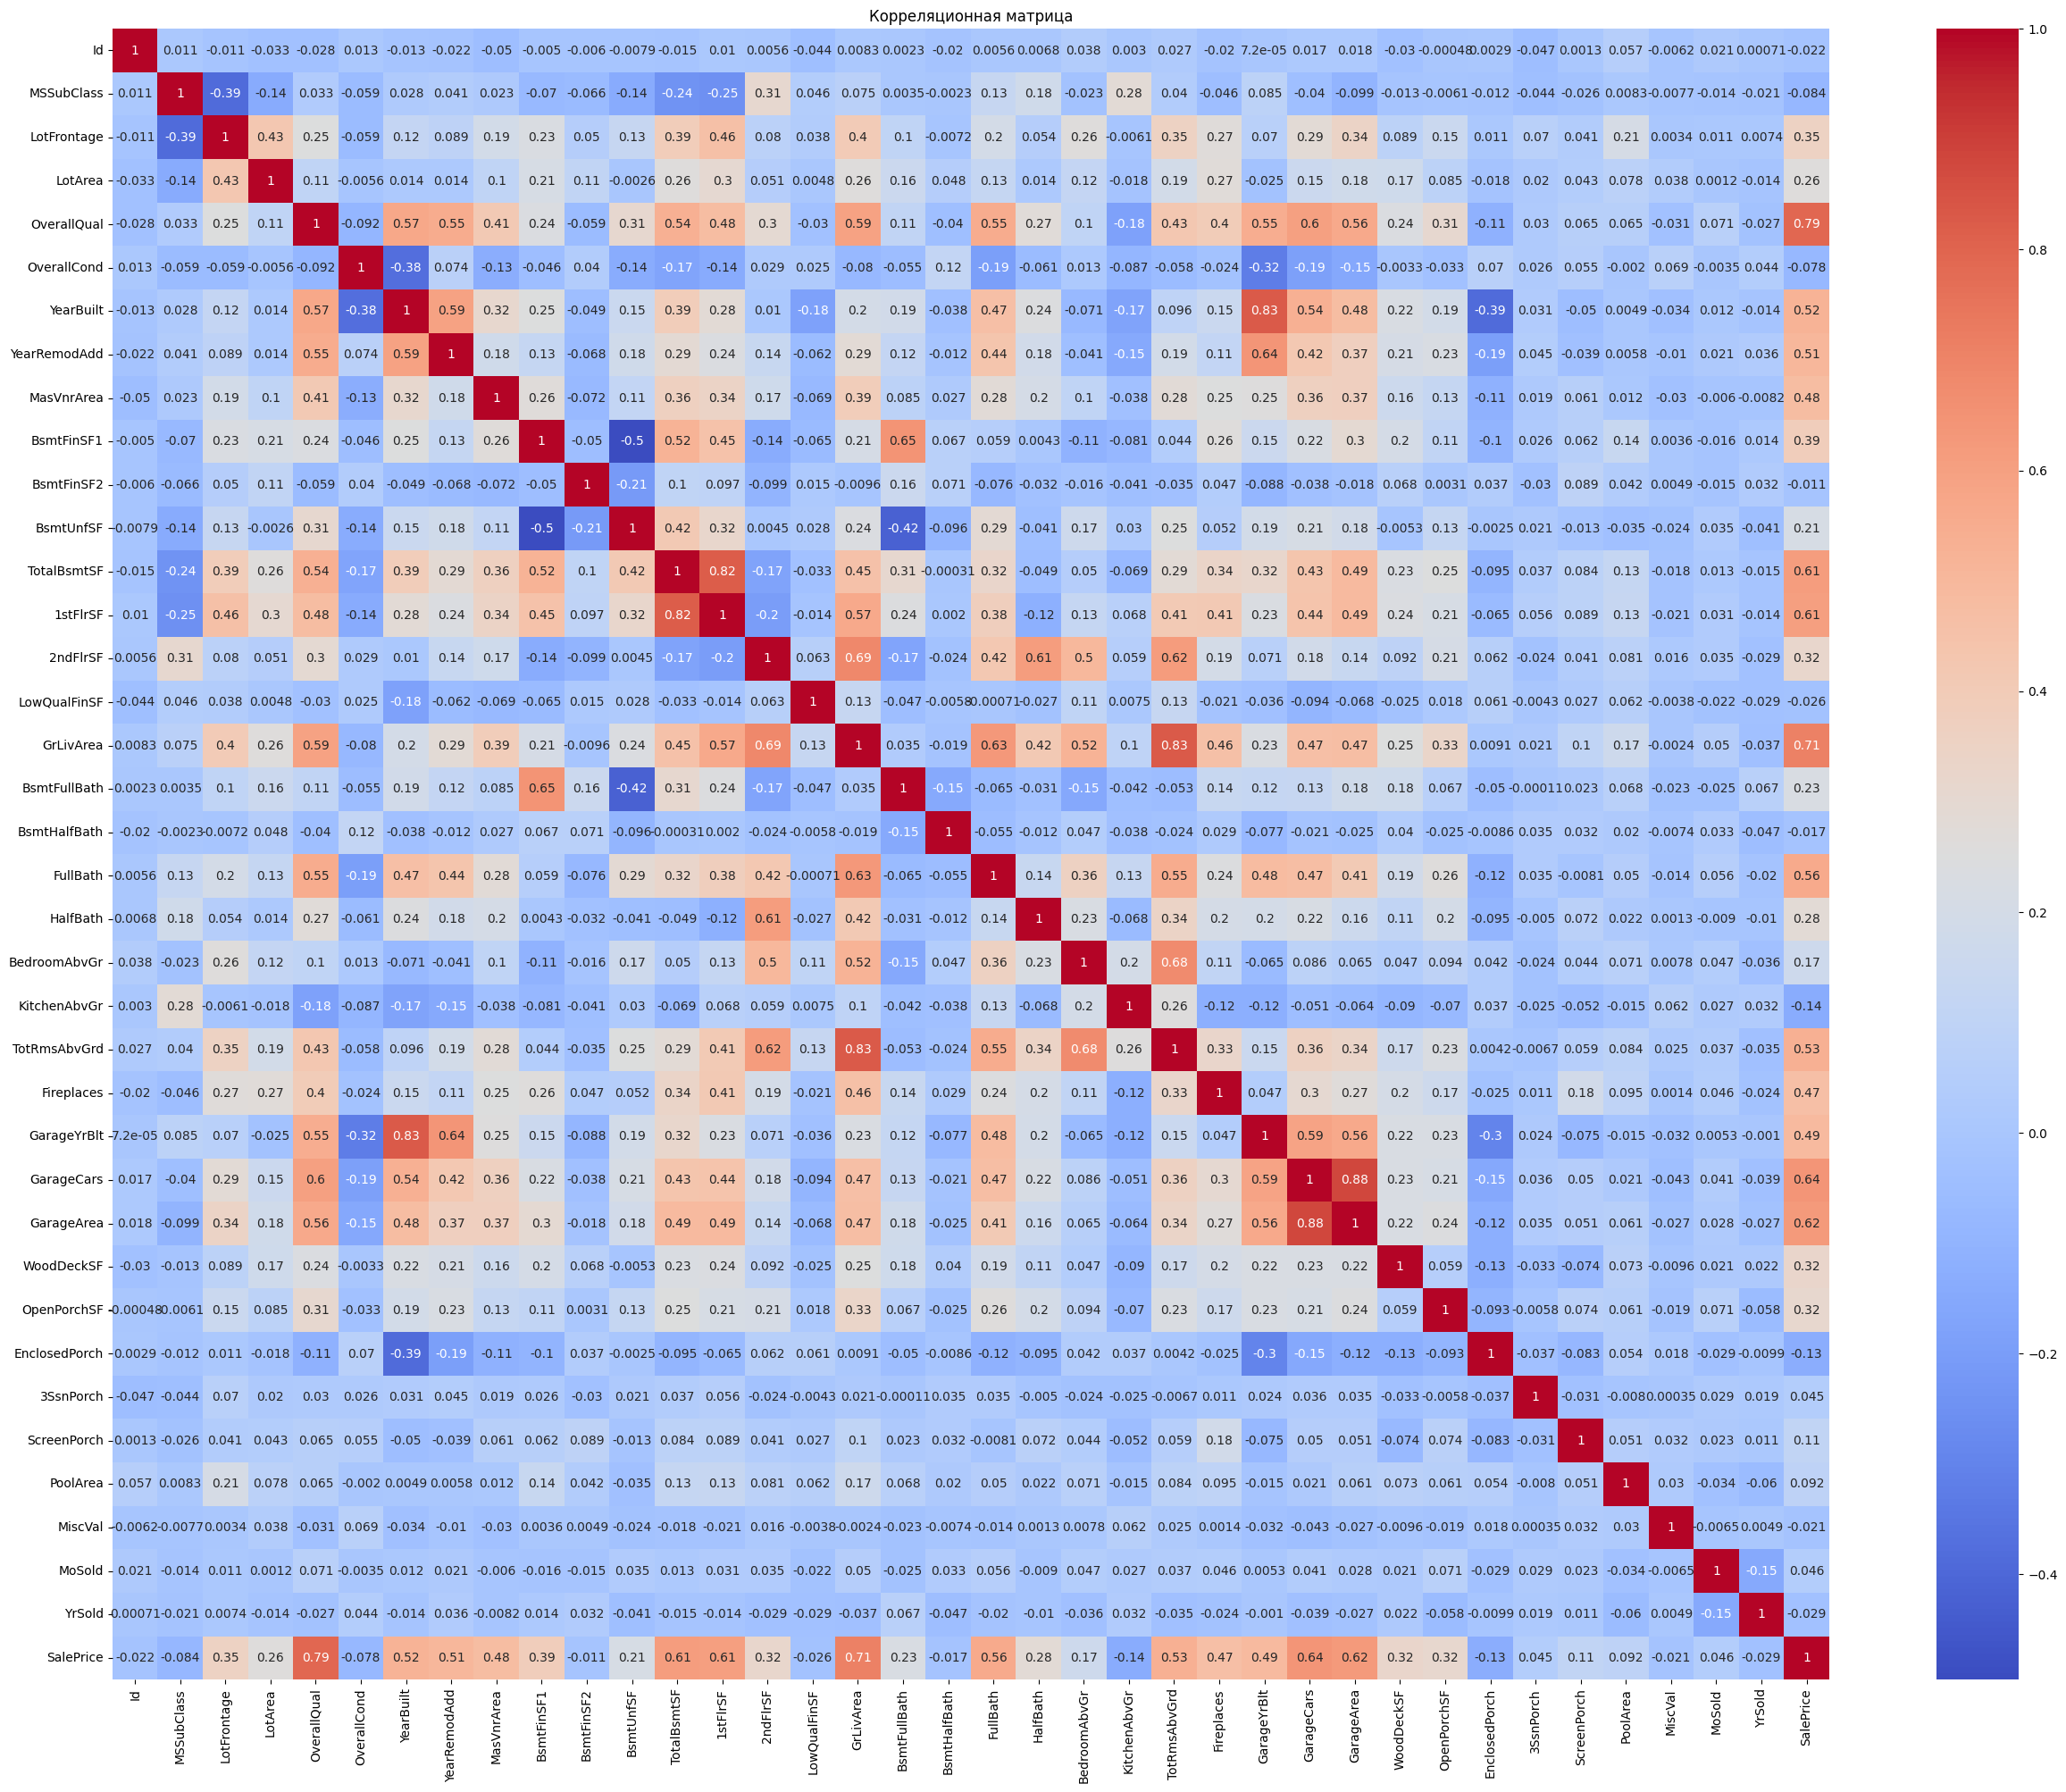

In [225]:
plt.figure(figsize=(31,24))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

# Посмотрим как распределена целевая переменная

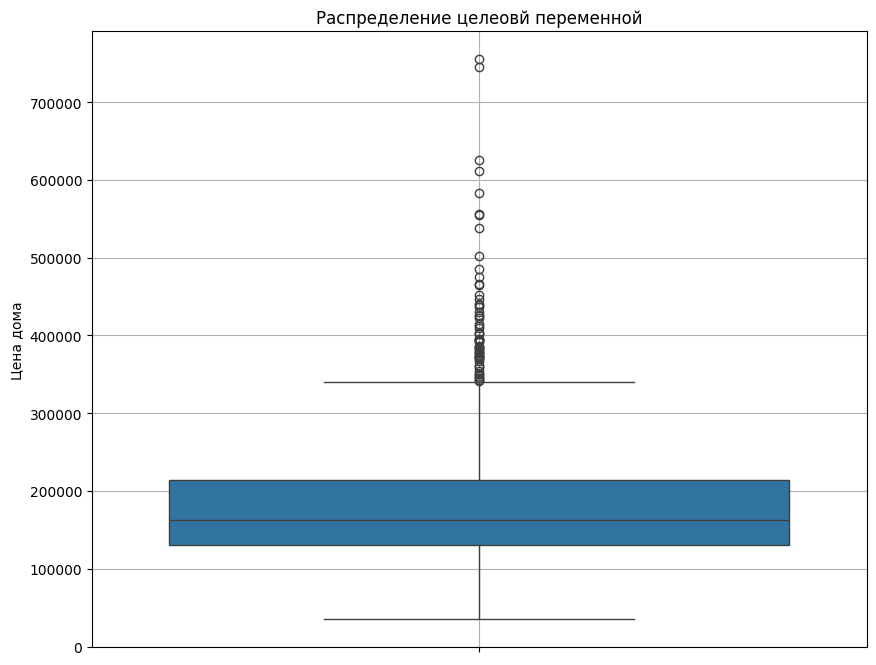

In [226]:
plt.figure(figsize=(10, 8)) 
sns.boxplot(data = HouseDF['SalePrice'])
plt.title("Распределение целеовй переменной")
plt.ylabel("Цена дома")
plt.grid(True)
plt.show()

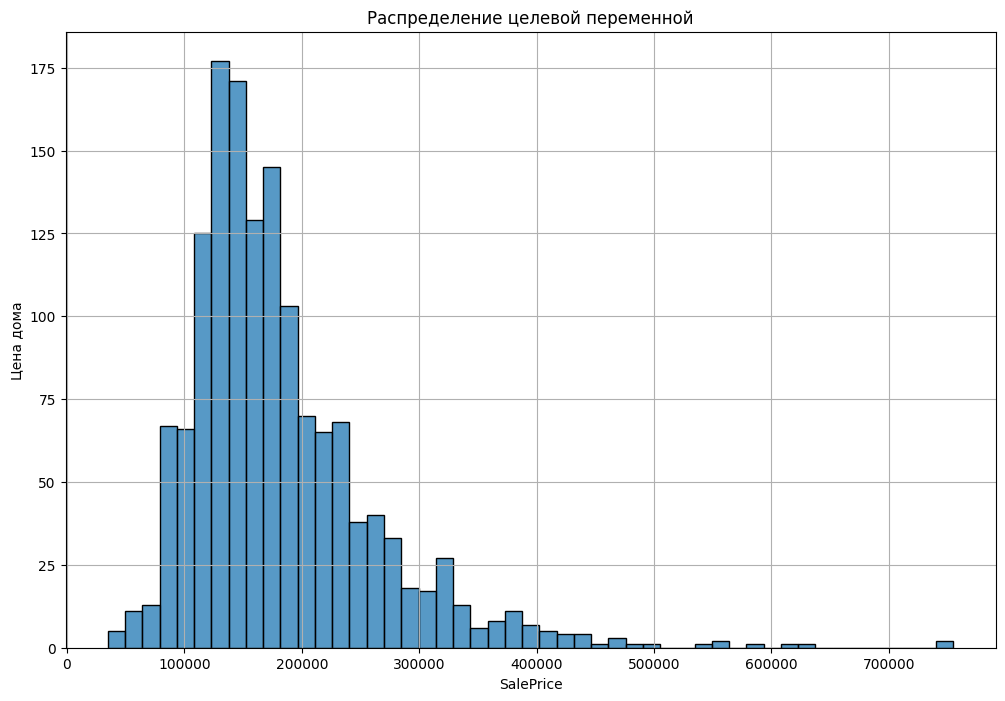

In [227]:
plt.figure(figsize=(12, 8)) 

sns.histplot(data = HouseDF['SalePrice'])
plt.title("Распределение целевой переменной")
plt.ylabel("Цена дома")
plt.grid(True)
plt.show()

## 2. Предобработка данных

### Для начала, уберем id (не несет инфрормации)

In [228]:
HouseDF.drop('Id', axis = 1, inplace = True)

### Посмотрим сколько у нас пропущенных значений

In [ ]:
HouseDF_nulls = round((HouseDF.isna().sum()) / 1460, 3)
HouseDF_nulls = HouseDF_nulls[HouseDF_nulls > 0]
print(HouseDF_nulls)    

LotFrontage     0.177
Alley           0.938
MasVnrType      0.597
MasVnrArea      0.005
BsmtQual        0.025
BsmtCond        0.025
BsmtExposure    0.026
BsmtFinType1    0.025
BsmtFinType2    0.026
Electrical      0.001
FireplaceQu     0.473
GarageType      0.055
GarageYrBlt     0.055
GarageFinish    0.055
GarageQual      0.055
GarageCond      0.055
PoolQC          0.995
Fence           0.808
MiscFeature     0.963
dtype: float64


### Удалим те, где нулевых значений больше 35%

In [230]:
def del_nans(DF, DF_nulls):
    count = 0
    for name, value in DF_nulls.items():
        if value >= 0.35:
            DF.drop(name, axis = 1, inplace = True)
            count += 1

    print('Удалено:', count)  
    return DF

In [231]:
del_nans(HouseDF, HouseDF_nulls)

Удалено: 6


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


### Давайте уберем столбцы, в которых корреляция с SalePrice меньше чем 15% (по модулю)

In [232]:
count = 0

LowCorrDF = pd.DataFrame()

for name, feature in correlation_matrix['SalePrice'].items():
    if name in HouseDF.columns and abs(feature) < 0.15:
        #LowCorrDF[name] = HouseDF[name]
        #HouseDF.drop(name, axis = 1, inplace = True)
        #count += 1
        pass

print('Удалено:', count)

Удалено: 0


### Получим такой датафрейм

In [233]:
HouseDF.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


### Разделим на выборки на train и test для начальной модели

In [234]:
X = HouseDF.drop('SalePrice', axis = 1)
y = HouseDF['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## 3. Подбор гиперпараметров

In [235]:
def find_cat_features(DF):    
    cat_features = []

    for column in DF.columns:
        if DF[column].dtype == 'object':
            cat_features.append(column)

    return cat_features

In [236]:
def transform_df(X_train, X_test): 
    cat_features = find_cat_features(X_train)

    if cat_features is not None:
            for col in cat_features:
                if X_train[col].isnull().any():
                    X_train[col] = X_train[col].astype(str).fillna('nan')
                else:
                    X_train[col] = X_train[col].astype(str)

                if len(X_test) != 0:
                    if X_test[col].isnull().any():
                        X_test[col] = X_test[col].astype(str).fillna('nan')
                    else:
                        X_test[col] = X_test[col].astype(str)
    return cat_features
cat_features = transform_df(X_train, X_test)

In [237]:
def optimize_on_train(X_train, y_train, cat_features = None, n_trials = 5, random_seed = 42):
     
    X_train = X_train.copy()

    if cat_features is not None:
        for col in cat_features:
            if X_train[col].isnull().any():
                X_train[col] = X_train[col].astype(str).fillna('nan')
            else:
                X_train[col] = X_train[col].astype(str)

    def objective(trial):
        params = {
            'iterations': 1500,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'random_strength': trial.suggest_float('random_strength', 0, 2),
            'loss_function': 'MAE',
            'verbose': 100,
            'random_seed': random_seed,
            'task_type': 'GPU',
            'cat_features': cat_features,
        }

        model = CatBoostRegressor(**params)

        cv = KFold(n_splits=3, shuffle=True, random_state = random_seed)
        mae_scorer = make_scorer(mean_absolute_error, greater_is_better = False)
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring = mae_scorer, n_jobs=-1)

        return scores.mean()
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    return study.best_params, -study.best_value

In [238]:
flag = False

if flag:    
    cat_features = find_cat_features(X_train)
    best_params, best_mae = optimize_on_train(X_train, y_train, cat_features = cat_features, n_trials = 5)
    print('Лучшие параметры:', best_params)
    print('Лучшее MAE на train:', best_mae)

    with open('params.json', 'w') as fp:
        json.dump(best_params, fp)

In [239]:
f = open('params.json')
params = json.load(f)
f.close()

In [240]:
params

{'learning_rate': 0.01530288832254053,
 'depth': 7,
 'l2_leaf_reg': 5.244071314568636,
 'bagging_temperature': 0.03465869197129878,
 'random_strength': 0.11914720809458368}

In [241]:
model = CatBoostRegressor(**params)

model.fit(X_train, y_train, cat_features = cat_features)

0:	learn: 76606.1311483	total: 32.9ms	remaining: 32.9s
1:	learn: 75819.8487801	total: 73.9ms	remaining: 36.9s
2:	learn: 75054.0191655	total: 115ms	remaining: 38.1s
3:	learn: 74319.7297844	total: 155ms	remaining: 38.5s
4:	learn: 73589.5751061	total: 202ms	remaining: 40.2s
5:	learn: 72842.7385288	total: 243ms	remaining: 40.3s
6:	learn: 72132.4928458	total: 285ms	remaining: 40.4s
7:	learn: 71418.8072641	total: 323ms	remaining: 40.1s
8:	learn: 70712.5475603	total: 364ms	remaining: 40.1s
9:	learn: 70004.2119063	total: 403ms	remaining: 39.9s
10:	learn: 69328.8820866	total: 440ms	remaining: 39.6s
11:	learn: 68659.6411396	total: 480ms	remaining: 39.5s
12:	learn: 67993.8925652	total: 518ms	remaining: 39.3s
13:	learn: 67305.3307807	total: 569ms	remaining: 40s
14:	learn: 66670.0291631	total: 611ms	remaining: 40.2s
15:	learn: 66042.2325771	total: 655ms	remaining: 40.3s
16:	learn: 65409.9863885	total: 697ms	remaining: 40.3s
17:	learn: 64760.2517104	total: 736ms	remaining: 40.1s
18:	learn: 64158.532

### Посмотрим на метрики на данном этапе

In [242]:
def check_metrics(model, X_test, y_test):  
    predict = model.predict(X_test)

    MAE_score_catboost = mean_absolute_error(y_test, predict)
    R2_score_catboost = r2_score(y_test, predict)
    RMSE_score_catboost = root_mean_squared_error(np.log(y_test), np.log(predict))

    print("MAE на test для catboost модели:", MAE_score_catboost)
    print("R2 на test для catboost модели:", R2_score_catboost)
    print("RMSE логарифма на test для catboost модели:", RMSE_score_catboost)

In [243]:
check_metrics(model, X_test, y_test)

MAE на test для catboost модели: 15116.375351672083
R2 на test для catboost модели: 0.9090408665818045
RMSE логарифма на test для catboost модели: 0.12144659820730024


## 4. Посмотрим на feature importances

In [ ]:
model_feature_importances = model.feature_importances_
names = X_train.columns
model_features = dict()
for i in range(len(names)):
    model_features[names[i]] = model_feature_importances[i]

In [245]:
model_features = sorted(model_features.items(), key=lambda item: item[1])

In [246]:
model_features

[('Street', np.float64(0.0)),
 ('Condition2', np.float64(0.0)),
 ('BsmtFinType2', np.float64(0.0)),
 ('BsmtHalfBath', np.float64(0.0)),
 ('Utilities', np.float64(6.549692732141132e-05)),
 ('Heating', np.float64(0.0001533902778112354)),
 ('MiscVal', np.float64(0.00017890964463704103)),
 ('3SsnPorch', np.float64(0.0015337702040506438)),
 ('GarageQual', np.float64(0.0035592000887584214)),
 ('GarageType', np.float64(0.004611625671568897)),
 ('LowQualFinSF', np.float64(0.0057065754336161085)),
 ('EnclosedPorch', np.float64(0.005849505313834181)),
 ('GarageCond', np.float64(0.009009969986977052)),
 ('HouseStyle', np.float64(0.00944903072568212)),
 ('BldgType', np.float64(0.009966045421496398)),
 ('Electrical', np.float64(0.017726837724669944)),
 ('BsmtCond', np.float64(0.018538812169033466)),
 ('RoofMatl', np.float64(0.0209563758302767)),
 ('BsmtFinType1', np.float64(0.022964060853781096)),
 ('Exterior2nd', np.float64(0.023424290622618287)),
 ('Exterior1st', np.float64(0.027758597758191825))

### Уберем признаки с важностью меньше 0.01

In [247]:
def feature_del(border, DF, model_features):
    HouseDF_cut = DF.copy()

    ignore = []
    for column, value in model_features:
        if value < border:
            HouseDF_cut.drop(column, axis = 1, inplace = True)
            ignore.append(column)
    
    return HouseDF_cut, ignore

In [248]:
def new_data(border, DF, model_features):
    new_DF, _ = feature_del(border, DF, model_features)

    X = new_DF.drop('SalePrice', axis = 1)
    y = new_DF['SalePrice']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


    cat_features = transform_df(X_train, X_test)

    return X_train, X_test, y_train, y_test, cat_features

In [249]:
X_train_1, X_test_1, y_train_1, y_test_1, cat_features_1 = new_data(0.01, HouseDF, model_features)

model_1 = CatBoostRegressor(**params)

model_1.fit(X_train_1, y_train_1, cat_features = cat_features_1)

0:	learn: 76597.6663580	total: 29.7ms	remaining: 29.7s
1:	learn: 75824.0834874	total: 64.9ms	remaining: 32.4s
2:	learn: 75037.1950267	total: 101ms	remaining: 33.6s
3:	learn: 74285.6336949	total: 137ms	remaining: 34s
4:	learn: 73525.8056469	total: 178ms	remaining: 35.4s
5:	learn: 72773.2503565	total: 215ms	remaining: 35.7s
6:	learn: 72040.5326468	total: 250ms	remaining: 35.4s
7:	learn: 71315.7523740	total: 288ms	remaining: 35.6s
8:	learn: 70619.7505521	total: 326ms	remaining: 35.9s
9:	learn: 69945.0650157	total: 364ms	remaining: 36s
10:	learn: 69255.4155573	total: 400ms	remaining: 36s
11:	learn: 68566.7927817	total: 436ms	remaining: 35.9s
12:	learn: 67882.8818382	total: 474ms	remaining: 36s
13:	learn: 67232.4562618	total: 511ms	remaining: 36s
14:	learn: 66620.7914017	total: 548ms	remaining: 36s
15:	learn: 66003.5952849	total: 585ms	remaining: 36s
16:	learn: 65394.9016689	total: 623ms	remaining: 36s
17:	learn: 64779.5560916	total: 660ms	remaining: 36s
18:	learn: 64169.4725788	total: 698m

In [250]:
check_metrics(model_1, X_test_1, y_test_1)

MAE на test для catboost модели: 14809.675763430514
R2 на test для catboost модели: 0.9127351372265603
RMSE логарифма на test для catboost модели: 0.12008730622821145


### Качество выросло, тогда попробуем убрать еще данные с важностью < 0.05

In [251]:
X_train_2, X_test_2, y_train_2, y_test_2, cat_features_2 = new_data(0.05, HouseDF, model_features)

model_2 = CatBoostRegressor(**params)

model_2.fit(X_train_2, y_train_2, cat_features = cat_features_2)

0:	learn: 76646.2353335	total: 38.9ms	remaining: 38.8s
1:	learn: 75874.0445836	total: 76.4ms	remaining: 38.1s
2:	learn: 75089.4427209	total: 106ms	remaining: 35.1s
3:	learn: 74299.8462057	total: 135ms	remaining: 33.6s
4:	learn: 73561.4991804	total: 174ms	remaining: 34.6s
5:	learn: 72843.1399021	total: 210ms	remaining: 34.8s
6:	learn: 72120.9296194	total: 242ms	remaining: 34.3s
7:	learn: 71408.4451297	total: 274ms	remaining: 34s
8:	learn: 70676.6089459	total: 306ms	remaining: 33.7s
9:	learn: 69985.8407993	total: 336ms	remaining: 33.3s
10:	learn: 69327.0779439	total: 368ms	remaining: 33.1s
11:	learn: 68658.6522000	total: 402ms	remaining: 33.1s
12:	learn: 67998.1617741	total: 435ms	remaining: 33s
13:	learn: 67343.6720519	total: 463ms	remaining: 32.6s
14:	learn: 66702.1756504	total: 495ms	remaining: 32.5s
15:	learn: 66045.7667108	total: 523ms	remaining: 32.2s
16:	learn: 65431.5232256	total: 554ms	remaining: 32s
17:	learn: 64851.5536064	total: 582ms	remaining: 31.8s
18:	learn: 64267.4765344

In [252]:
check_metrics(model_2, X_test_2, y_test_2)

MAE на test для catboost модели: 15202.402702744992
R2 на test для catboost модели: 0.9137713340344995
RMSE логарифма на test для catboost модели: 0.1210563593167511


### Качество упало (на MAE и RSME), значит убрали уже лишнее. Остановимся на model_1.

## 5. Исследуем число итераций

In [253]:
def iterations_study(X_train, X_test, y_train, y_test, cat_features, params, start = 100, end = 3000, step = 100):
    n = (end - start) // step + 1

    train_metrics = np.zeros((n, 3))
    test_metrics = np.zeros((n, 3))
    all_steps = []

    last_model = None

    for local_step in range(start, end + 1, step):
        index = local_step // step - 1
        
        all_steps.append(local_step)

        params['iterations'] = step

        model = CatBoostRegressor(**params)

        model.fit(X_train, y_train, cat_features = cat_features, init_model = None if local_step == 100 else last_model, use_best_model=False)

        predict_train = model.predict(X_train)
        predict_test = model.predict(X_test)

        train_metrics[index][0] = mean_absolute_error(y_train, predict_train)
        train_metrics[index][1]= r2_score(y_train, predict_train)
        train_metrics[index][2] = root_mean_squared_error(np.log(y_train), np.log(predict_train))

        test_metrics[index][0] = mean_absolute_error(y_test, predict_test)
        test_metrics[index][1] = r2_score(y_test, predict_test)
        test_metrics[index][2] = root_mean_squared_error(np.log(y_test), np.log(predict_test))

        last_model = model

        print('Here!')

    return train_metrics, test_metrics, all_steps

In [254]:
train_metrics, test_metrics, all_steps = iterations_study(X_train_1, X_test_1, y_train_1, y_test_1, cat_features_1, params)

0:	learn: 76604.0491584	total: 29.9ms	remaining: 2.96s
1:	learn: 75819.2700886	total: 55.8ms	remaining: 2.74s
2:	learn: 75044.7510841	total: 80.4ms	remaining: 2.6s
3:	learn: 74343.8317641	total: 107ms	remaining: 2.56s
4:	learn: 73563.4924628	total: 135ms	remaining: 2.56s
5:	learn: 72843.9287383	total: 163ms	remaining: 2.56s
6:	learn: 72113.7646681	total: 192ms	remaining: 2.55s
7:	learn: 71362.7615816	total: 222ms	remaining: 2.55s
8:	learn: 70671.6596382	total: 250ms	remaining: 2.53s
9:	learn: 70012.2844124	total: 278ms	remaining: 2.5s
10:	learn: 69356.4489683	total: 306ms	remaining: 2.47s
11:	learn: 68687.0394917	total: 334ms	remaining: 2.45s
12:	learn: 68023.2891106	total: 361ms	remaining: 2.42s
13:	learn: 67355.4882075	total: 386ms	remaining: 2.37s
14:	learn: 66706.9427269	total: 415ms	remaining: 2.35s
15:	learn: 66081.2593684	total: 445ms	remaining: 2.34s
16:	learn: 65441.7681764	total: 470ms	remaining: 2.3s
17:	learn: 64832.2207014	total: 495ms	remaining: 2.26s
18:	learn: 64234.869

In [255]:
def create_plots(train_metrics, test_metrics, all_steps):
    train_metrics = train_metrics.T
    test_metrics = test_metrics.T

    metrics = ['MAE', 'R2', 'RMSE от логарифма']

    for index in range(3):
        plt.figure(figsize=(12, 8)) 
        plt.plot(all_steps, train_metrics[index], label = "Train")
        plt.plot(all_steps, test_metrics[index], label = "Test")
        plt.title("Метрика " + metrics[index] + " на train и test")
        plt.ylabel(metrics[index])
        plt.xlabel("Число итераций")
        plt.grid(True)
        plt.legend()
        plt.show()
        

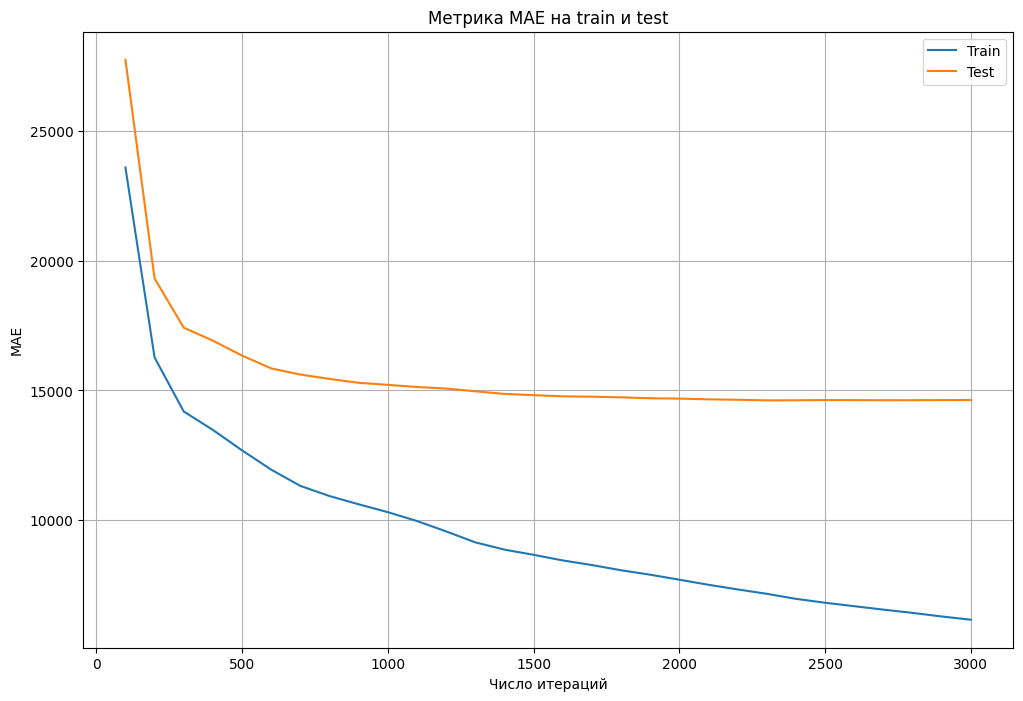

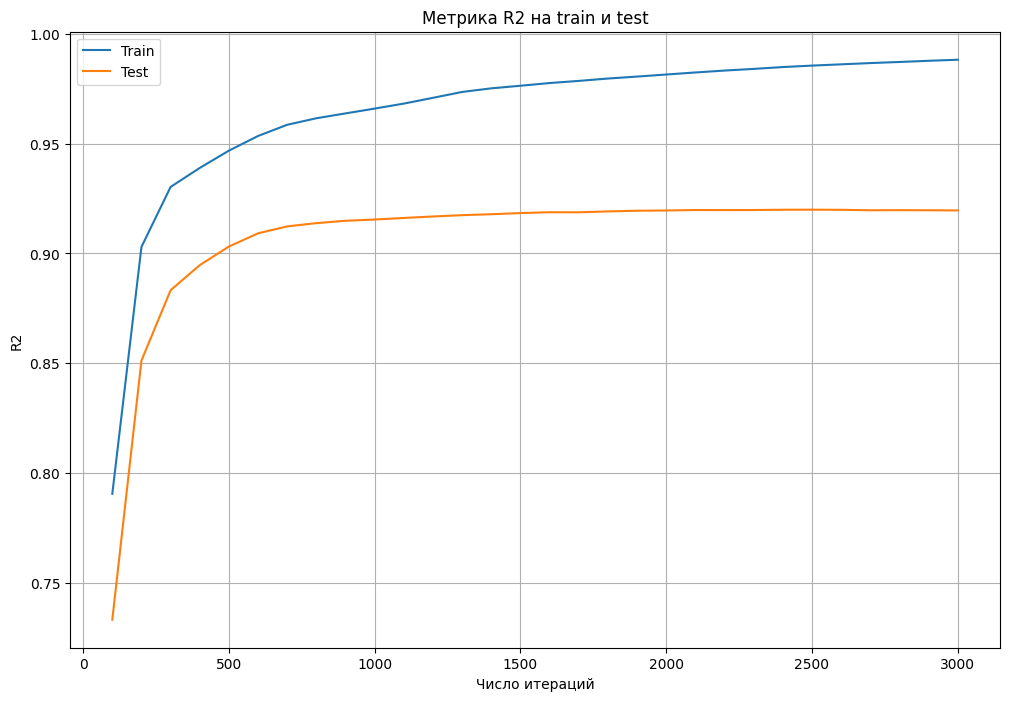

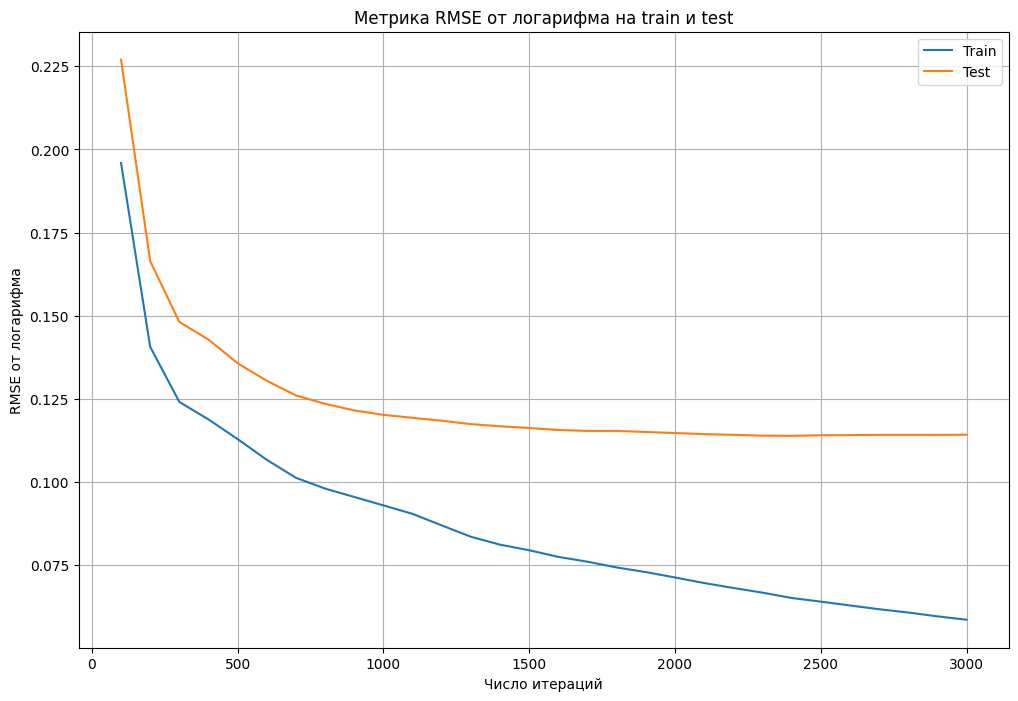

In [256]:
create_plots(train_metrics, test_metrics, all_steps)

### Остановимся на 1500 итераций

In [329]:
params['iterations'] = 1500
params['verbose'] = 0
params['task_type'] = 'GPU'

## 6. Обучим финальную модель 

In [330]:
X_test = pd.read_csv('test.csv')

del_nans(X_test, HouseDF_nulls)
test_preds = pd.DataFrame(X_test['Id'])
test_preds['SalePrice'] = [0] * len(X_test['Id'])
X_test.drop('Id', axis = 1, inplace = True)

HouseDF_cut, _ = feature_del(0.01, HouseDF, model_features) # Убираем фичи с маленькой значимостью
X_test, _ = feature_del(0.01, X_test, model_features) # Убираем фичи с маленькой значимостью
y_train = HouseDF_cut['SalePrice']
HouseDF_cut.drop('SalePrice', axis = 1, inplace = True)
cat_features = transform_df(HouseDF_cut, X_test) # Обрабатываем nan

Удалено: 6


In [331]:
model_1 = CatBoostRegressor(**params)

folds = KFold(n_splits = 7, shuffle=True, random_state = 42)

for train_idx, val_idx in tqdm(folds.split(HouseDF_cut)):
    X_tr, X_val = HouseDF_cut.iloc[train_idx], HouseDF_cut.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model_1.fit(X_tr, y_tr, eval_set=(X_val, y_val), cat_features = cat_features, use_best_model=True)
    check_metrics(model_1, X_val, y_val)
    print()
    test_preds['SalePrice'] += model_1.predict(X_test) / folds.n_splits

test_preds.to_csv('submission.csv', index=False)

1it [01:41, 101.27s/it]

MAE на test для catboost модели: 17964.40191897552
R2 на test для catboost модели: 0.9073771453110009
RMSE логарифма на test для catboost модели: 0.1407953624208551



2it [05:32, 177.54s/it]

MAE на test для catboost модели: 13811.230426812825
R2 на test для catboost модели: 0.9332604008354369
RMSE логарифма на test для catboost модели: 0.1108437281057322



3it [07:11, 141.66s/it]

MAE на test для catboost модели: 17937.964449119514
R2 на test для catboost модели: 0.862623969406004
RMSE логарифма на test для catboost модели: 0.13384754702520024



4it [08:35, 118.98s/it]

MAE на test для catboost модели: 23554.94981486418
R2 на test для catboost модели: 0.7504592900216536
RMSE логарифма на test для catboost модели: 0.18685124899949557



5it [10:12, 111.01s/it]

MAE на test для catboost модели: 17717.626622282678
R2 на test для catboost модели: 0.8680369372389306
RMSE логарифма на test для catboost модели: 0.15880233504889593



6it [11:46, 105.18s/it]

MAE на test для catboost модели: 16263.055358556889
R2 на test для catboost модели: 0.8974544250545173
RMSE логарифма на test для catboost модели: 0.12703489797328255



7it [13:27, 115.34s/it]

MAE на test для catboost модели: 15932.475689417079
R2 на test для catboost модели: 0.8918484538320185
RMSE логарифма на test для catboost модели: 0.1200835942977595



### На kaggle смог добиться 0.14008 (с раннее 0.14871 с тем же бустингом, но без хорошей обработки данных)

## 7. Оценим значимость признаков

In [ ]:
model_1_feature_importances = model_1.feature_importances_
names = HouseDF_cut.columns
model_1_features = dict()
for i in range(len(names)):
    model_1_features[names[i]] = model_1_feature_importances[i]
model_1_features = sorted(model_1_features.items(), key=lambda item: item[1])

In [333]:
model_1_features

[('HeatingQC', np.float64(0.0)),
 ('YrSold', np.float64(0.0)),
 ('PoolArea', np.float64(0.0006969081113165504)),
 ('MSSubClass', np.float64(0.0012807200536958654)),
 ('BsmtFullBath', np.float64(0.002773497126548046)),
 ('Exterior2nd', np.float64(0.003365556402028842)),
 ('Foundation', np.float64(0.005236543836753712)),
 ('ExterCond', np.float64(0.0074926372388735675)),
 ('BsmtFinType1', np.float64(0.008968549026588137)),
 ('Exterior1st', np.float64(0.009350018634746018)),
 ('Electrical', np.float64(0.00950198988491657)),
 ('ExterQual', np.float64(0.010803199245018191)),
 ('LotShape', np.float64(0.01097090710148682)),
 ('BedroomAbvGr', np.float64(0.014295842893020015)),
 ('RoofStyle', np.float64(0.01465124780595118)),
 ('RoofMatl', np.float64(0.027117647149808417)),
 ('SaleCondition', np.float64(0.038268779280277714)),
 ('BsmtFinSF2', np.float64(0.04228384556315566)),
 ('SaleType', np.float64(0.05241488881704553)),
 ('MasVnrArea', np.float64(0.06611725175416297)),
 ('LandSlope', np.floa

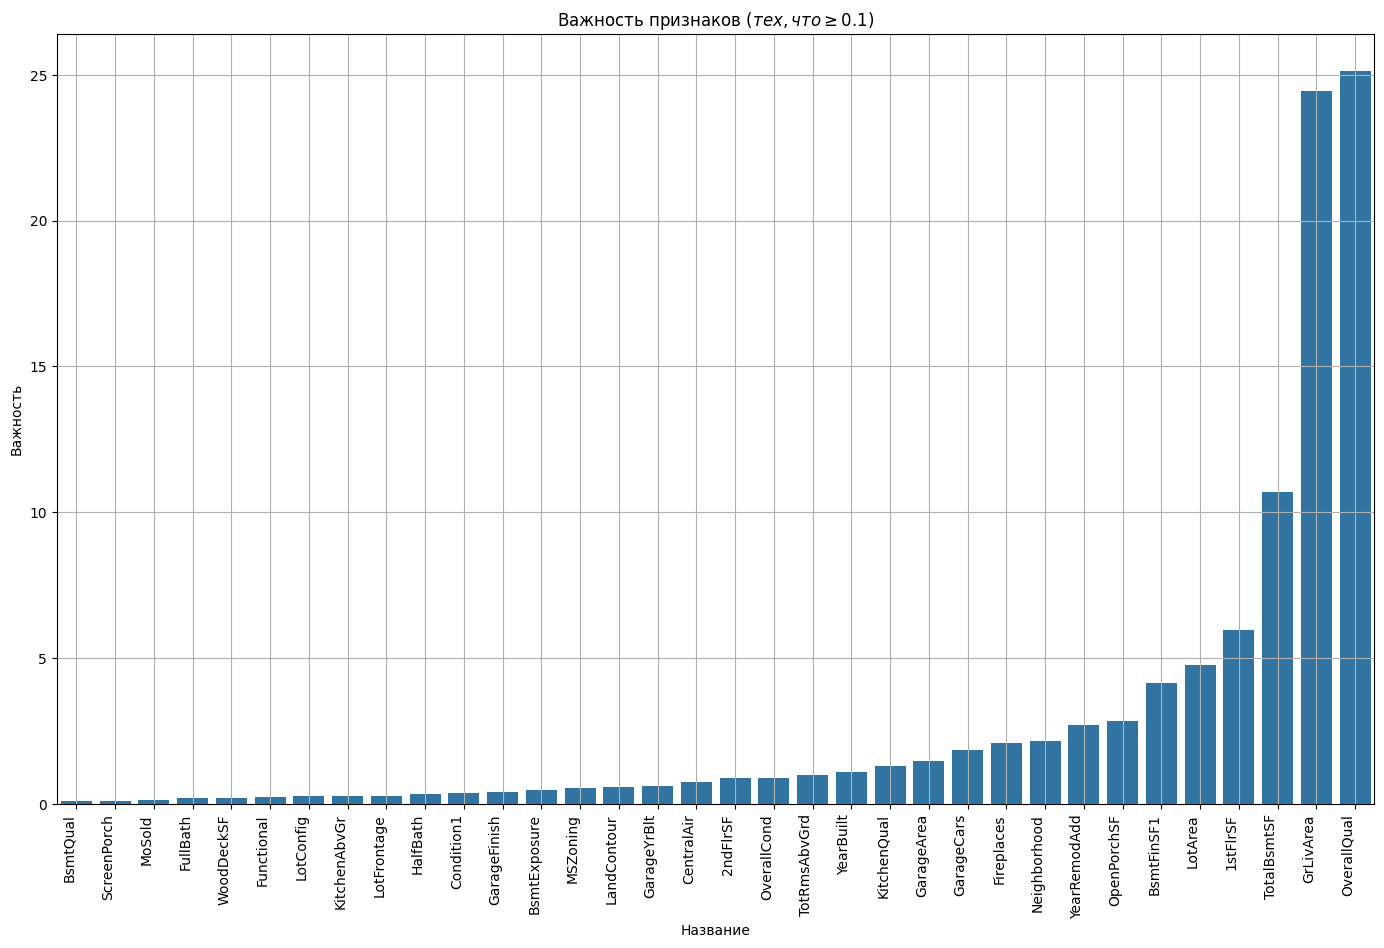

In [352]:
df_importance = pd.DataFrame(model_1_features, columns = ['Feature', 'Importance'])

plt.figure(figsize = (17, 10))
sns.barplot(data = df_importance[df_importance['Importance'] >= 0.1], x = 'Feature', y = 'Importance')

plt.xticks(rotation = 90, ha ='right')

plt.title(r'Важность признаков $(тех, что \geq 0.1)$')
plt.xlabel('Название')
plt.ylabel('Важность')
plt.grid(True)
plt.show()

### Видим, что наиболее значимые признаки (5 штук) это (по порядку значимости):
1. Общее качество
2. Общая жилая площадь
3. Размер подвала
4. Размер 1 этажа
5. Площадь земельного участка